<center><big><b>SegPore for RNA structure estimation</b></big></center>

The reference sequence is `miR17-92.fasta`. We use the partial alignment algorithm to map the signal segments with the reference sequence. Experiments were conducted on 1792_fl_con-multi (unmodified sample) and 1792_fl_mod_150-multi (modified sample, only the sample corresponding to 150mM AcIm).

In [1]:
import os
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import csv
from scipy.stats import norm


def read_res(file_name):
    df = pd.read_csv(file_name)
    df['end_pos'] = df['end_pos'] + 2
    end_pos_arr = list(df['end_pos'])

    words_count = dict()
    for i in range(951):
        words_count[i] = 0

    for end in end_pos_arr:
        words_count[end] += 1

    for i in words_count:
        words_count[i] /= len(df)
    print(f"{file_name} : {len(df)}")
    return words_count

def plot_end_density(x_arr, con_y, mod_y):

    fig, ax = plt.subplots(2, 1, sharey=True, figsize=(45, 12), dpi=200)
    font_size = 45
    fig.text(0.01, 0.5, 'Alignment end location density', va='center', rotation='vertical', fontsize=font_size)
    scale_ls = [i for i in range(0, 4)]
    index_ls = ['0', '1', '2', '3', '4', '6', '7', '8', '9']
    selected_points = [51, 103, 358, 399, 482, 521, 639, 668, 819, 831]
    selected_labels = [str(i + 1) for i in selected_points]
    selected_labels[6] = selected_labels[6] + "  "
    selected_labels[7] = "  " + selected_labels[7]
    selected_labels[8] = selected_labels[8] + "    "
    selected_labels[9] = "    " + selected_labels[9]

    ax1 = ax[0]
    # #A6611A
    # #FDC086
    ax1.plot(x_arr, con_y, color="#E7298A", linewidth=4.5, label="Unmodified")
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_linewidth(3)
    ax1.spines['bottom'].set_linewidth(3)
    ax1.axes.xaxis.set_ticklabels([])
    ax1.tick_params(width=3, length=12, labelsize=30)
    ax1.axes.yaxis.set_ticklabels([])
    # ax1.set_yticks(scale_ls)
    # ax1.set_yticklabels(index_ls, fontsize=20)
    ax1.set_ylim((0, 0.02))
    ax1.set_xlim((0, len(x_arr)))
    ax1.legend(loc="best", bbox_to_anchor=(0.15, 0.95), fontsize=font_size)

    ax2 = ax[1]
    ax2.plot(x_arr, mod_y, color="#A63BD4", linewidth=4.5, label="Modified")
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_linewidth(3)
    ax2.spines['bottom'].set_linewidth(3)
    ax2.axes.yaxis.set_ticklabels([])
    ax2.tick_params(width=3, length=12, labelsize=30)
    ax2.set_xticks(selected_points)
    ax2.set_xticklabels(selected_labels, fontsize=40)
    ax2.set_ylim((0, 0.02))
    ax2.set_xlim((0, len(x_arr)))
    ax2.legend(loc="best", bbox_to_anchor=(0.28, 0.95), fontsize=font_size)  # , frameon=False

    plt.subplots_adjust(left=0.04, right=0.99, top=0.85, bottom=0.07)
    plt.suptitle("End position distribution of modified sample and unmodified sample", fontsize=60)
    # plt.savefig("stoppoints.tif")
    plt.show()

1792_fl_con-multi_stop_points.csv : 31623
1792_fl_mod_150-multi_stop_points.csv : 34775


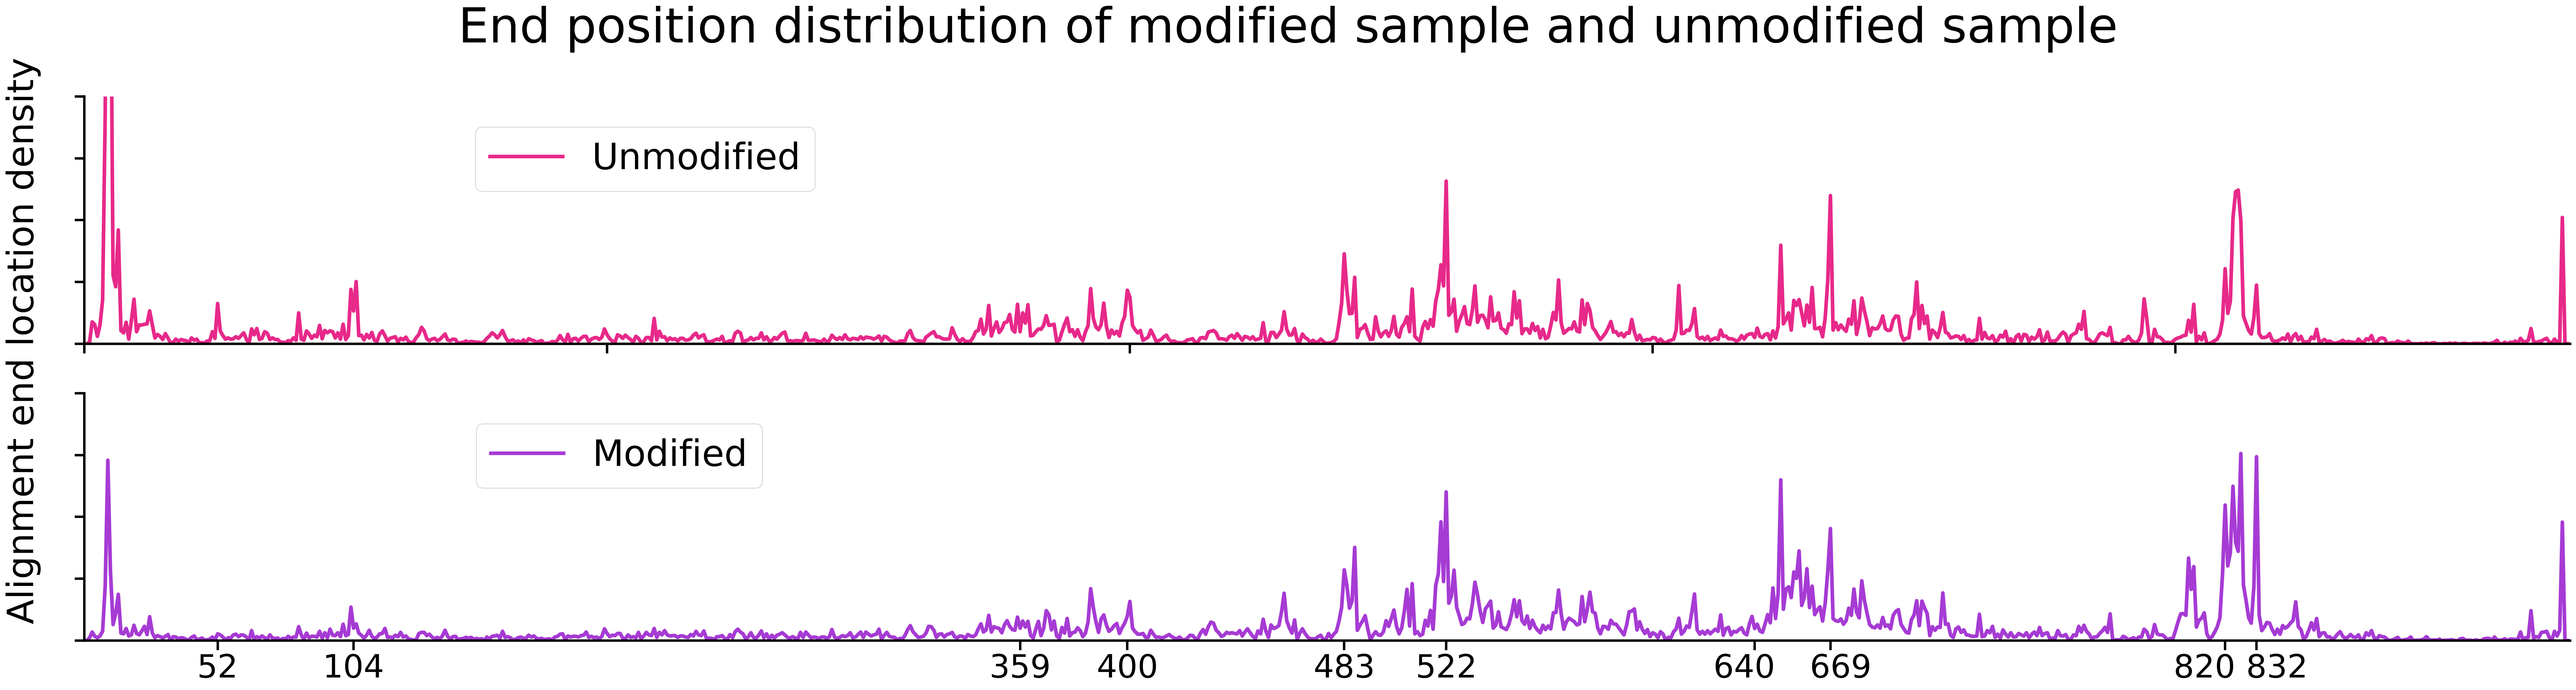

In [2]:
con_dict = read_res("1792_fl_con-multi_stop_points.csv")
x_arr = list(con_dict.keys())
con_y = list(con_dict.values())

mod_dict = read_res("1792_fl_mod_150-multi_stop_points.csv")
mod_y = list(mod_dict.values())

plot_end_density(x_arr, con_y, mod_y)

Next using GMM (fixed KNN) to estimate the modication rate for each site and get the result `model_kmer_RNA_folding.csv`.

In [3]:
def read_ref():
    with open("miR17-92.fasta", "r") as f:
        for idx, line in enumerate(f):
            if idx:
                ref = line.strip().replace("\r", "").replace("\n", "")
    return ref

ref = read_ref()
print(ref)
print(f"The reference sequence length is {len(ref)}.")

TGGTTTATAGTTGTTAGAGTTTGAGGTGTTAATTCTAATTATCTATTTCAAATTTAGCAGGAAAAAAGAGAACATCACCTTGTAAAACTGAAGATTGTGACCAGTCAGAATAATGTCAAAGTGCTTACAGTGCAGGTAGTGATATGTGCATCTACTGCAGTGAAGGCACTTGTAGCATTATGGTGACAGCTGCCTCGGGAAGCCAAGTTGGGCTTTAAAGTGCAGGGCCTGCTGATGTTGAGTGCTTTTTGTTCTAAGGTGCATCTAGTGCAGATAGTGAAGTAGATTAGCATCTACTGCCCTAAGTGCTCCTTCTGGCATAAGAAGTTATGTATTCATCCAATAATTCAAGCCAAGCAAGTATATAGGTGTTTTAATAGTTTTTGTTTGCAGTCCTCTGTTAGTTTTGCATAGTTGCACTACAAGAAGAATGTAGTTGTGCAAATCTATGCAAAACTGATGGTGGCCTGCTATTTCCTTCAAATGAATGATTTTTACTAATTTTGTGTACTTTTATTGTGTCGATGTAGAATCTGCCTGGTCTATCTGATGTGACAGCTTCTGTAGCACTAAAGTGCTTATAGTGCAGGTAGTGTTTAGTTATCTACTGCATTATGAGCACTTAAAGTACTGCTAGCTGTAGAACTCCAGCTTCGGCCTGTCGCCCAATCAAACTGTCCTGTTACTGAACACTGTTCTATGGTTAGTTTTGCAGGTTTGCATCCAGCTGTGTGATATTCTGCTGTGCAAATCCATGCAAAACTGACTGTGGTAGTGAAAAGTCTGTAGAAAAGTAAGGGAAACTCAAACCCCTTTCTACACAGGTTGGGATCGGTTGCAATGCTGTGTTTCTGTATGGTATTGCACTTGTCCCGGCCTGTTGAGTTTGGTGGGGATTGTGACCAGAAGATTTTGAAAATTAAATATTACTGAAGATTTCGACTTCCACTG
The reference sequence length is 951.


In [4]:
def read_model_kmer_with_pos(file_name):
    """
    Read model kmer and return a dict.
    :param file_name:
    :return:
    """
    model_kmer_pd = pd.read_csv(file_name, sep=',').to_dict('records')
    model_kmer_dict = dict()
    for item in model_kmer_pd:
        model_kmer_dict[item['pos']] = item
    return model_kmer_dict

model_kmer = read_model_kmer_with_pos("model_kmer_RNA_folding.csv")  # model_kmer_RNA_folding_v2_fix_KNN_20231009.csv

In [5]:
select_kmers_pos = [145, 285, 426, 599, 737, 851]

In [6]:
def plot_assit(refer_mu):
    plt.axvline(x=refer_mu, color="gray", ls='-.', linewidth=2.0)
    plt.ylim((0, 0.19))
    plt.xlim((refer_mu - 28, refer_mu + 28))


def plot_each_kmer(select_kmers_pos):
    
    plt.figure(figsize=(13, 3))
    binwidth = 0.5

    pal = sns.color_palette("pastel")
    pal_for_con = [pal[2]]
    pal_for_mod = [pal[2]] + [pal[3]]
    
    idx = 1
    for _pos in select_kmers_pos:
        kmer = model_kmer[_pos]['model_kmer']
        refer_mu = model_kmer[_pos]['model_mean']
        
        con_data = pd.read_csv(os.path.join("example_site_data", "1792_fl_con-multi_" + str(_pos) + ".csv"))
        con_data['label'] = 0
        
        mod_data = pd.read_csv(os.path.join("example_site_data", "1792_fl_mod_150-multi_" + str(_pos) + ".csv"))
        
        ax1 = plt.subplot(2, 6, idx)
        ax1_1 = sns.kdeplot(
        data=con_data, x="mean", hue="label",
        fill=True, common_norm=True, palette=pal_for_con,
        alpha=.5, linewidth=1.0, legend=False
        )
        ax1_1.set_xlabel("")
        ax1_1.set_ylabel("")
        ax1_1.set_xticks([])
        ax1_1.set_yticks([])
        plot_assit(refer_mu)
        plt.title(kmer)

        ax2 = plt.subplot(2, 6, idx+6)
        ax2_1 = sns.kdeplot(
        data=mod_data, x="mean", hue="label",
        fill=True, common_norm=True, palette=pal_for_mod,
        alpha=.5, linewidth=1.0, legend=False
        )
        ax2_1.set_xlabel("")
        ax2_1.set_ylabel("")
        ax2_1.set_xticks([])
        ax2_1.set_yticks([])
        plot_assit(refer_mu)
        
        idx += 1

    plt.subplots_adjust(left=0.0, right=1.0, top=1.0, bottom=0.0)
    plt.show()

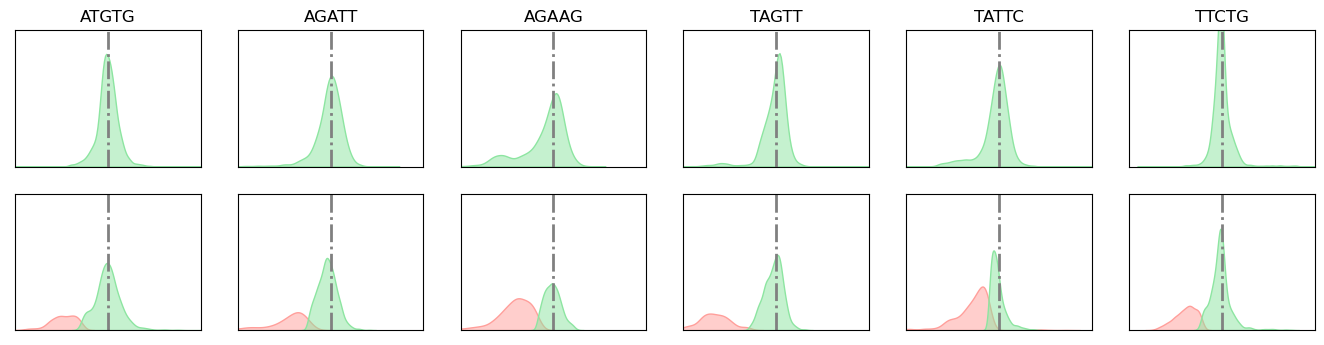

In [7]:
plot_each_kmer(select_kmers_pos)

In [8]:
scale_max = 4.0
scale_min = -0.5

df = pd.read_csv("model_kmer_RNA_folding.csv")
df['reactivity'] = df['model_mean'] - df['model_mean_mod']
df['reactivity'] = df['reactivity'].apply(lambda x: np.abs(x))
df['reactivity'] = df['reactivity'] * df['mod_rate']

max_v = max(list(df['reactivity']))
min_v = min(list(df['reactivity']))
print(f"Raw reactivity score: max value = {max_v}, min value = {min_v}.")

df['normalized_reactivity'] = df['reactivity'].apply(lambda x: (scale_max - scale_min) * (x - min_v) /
                                                                   (max_v - min_v) + scale_min)


max_v = max(list(df['normalized_reactivity']))
min_v = min(list(df['normalized_reactivity']))
print(f"Normalized reactivity score: max value = {max_v}, min value = {min_v}.")

pos2score_dict = df.set_index('pos')['normalized_reactivity'].to_dict()

with open("segPore_reactivity.dat", 'w', newline="") as f:
    writer = csv.writer(f, delimiter='\t')
    for i in range(951):
        pos = i
        if pos in pos2score_dict:
            writer.writerow([pos + 1, pos2score_dict[pos]])
        else:
            writer.writerow([pos + 1, -999.00])

Raw reactivity score: max value = 7.5770087546900005, min value = 0.0.
Normalized reactivity score: max value = 4.0, min value = -0.5.


In [9]:
def smooth(y, box_pts=10):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


def plot_reactivity(selected_points):
    df1 = pd.read_csv("1792_1ai_miR17-92_DNA.dat", sep='\t', header=None)
    df1.columns = ['POS', 'REACTIVITY']
    for idx, row in df1.iterrows():
        if row['REACTIVITY'] == -999.00:
            df1.loc[idx, 'REACTIVITY'] = 0.00
    case1_arr = list(df1['REACTIVITY'])
#     print(np.max(case1_arr))
#     print(np.min(case1_arr))
    x_arr = np.arange(len(case1_arr))

    df2 = pd.read_csv("segPore_reactivity.dat", sep='\t', header=None)
    df2.columns = ['POS', 'REACTIVITY']
    for idx, row in df2.iterrows():
        if row['REACTIVITY'] == -999.00:
            df2.loc[idx, 'REACTIVITY'] = 0.00
    case2_arr = list(df2['REACTIVITY'])

    fig, ax = plt.subplots(2, 1, sharey=True, figsize=(45, 10), dpi=100)
    font_size = 45
    fig.text(0.01, 0.5, 'Normalized reactivity', va='center', rotation='vertical', fontsize=font_size)
    scale_ls = [i for i in range(0, 5)]
    index_ls = ['0', '1', '2', '3', '4']
    selected_labels = [str(i+1) for i in selected_points]


    ax1 = ax[0]
    ax1.plot(x_arr, case1_arr, color="#2C7BB6", linewidth=4.5, label="SHAPE-MaP")
    for i in selected_points:
        ax1.axvline(x=i, ls='--', linewidth=4.0, color="black")
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_linewidth(3)
    ax1.spines['bottom'].set_linewidth(3)
    ax1.axes.xaxis.set_ticklabels([])
    ax1.tick_params(width=3, length=12, labelsize=30)
    ax1.set_yticks(scale_ls)
    # ax1.set_yticklabels(index_ls, fontsize=20)
    ax1.set_ylim((-0.8, 4.0))
    ax1.set_xlim((0, len(x_arr)))
    ax1.legend(loc=1, fontsize=font_size)

    ax2 = ax[1]
    case2_arr_smooth = smooth(case2_arr, 2)
    ax2.plot(x_arr, case2_arr_smooth, color="#91CF60", linewidth=4.5, label="SegPore")
    for i in selected_points:
        ax2.axvline(x=i, ls='--', linewidth=4.0, color="black")
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_linewidth(3)
    ax2.spines['bottom'].set_linewidth(3)
    # ax2.axes.xaxis.set_ticklabels([])
    ax2.tick_params(width=3, length=12, labelsize=30)
    ax2.set_xticks(selected_points)
    ax2.set_xticklabels(selected_labels, fontsize=40)
    ax2.set_ylim((-0.8, 4.0))
    ax2.set_xlim((0, len(x_arr)))
    ax2.legend(loc=1, fontsize=font_size)  # , frameon=False

    plt.subplots_adjust(left=0.04, right=0.99, top=0.95, bottom=0.07)
    plt.show()

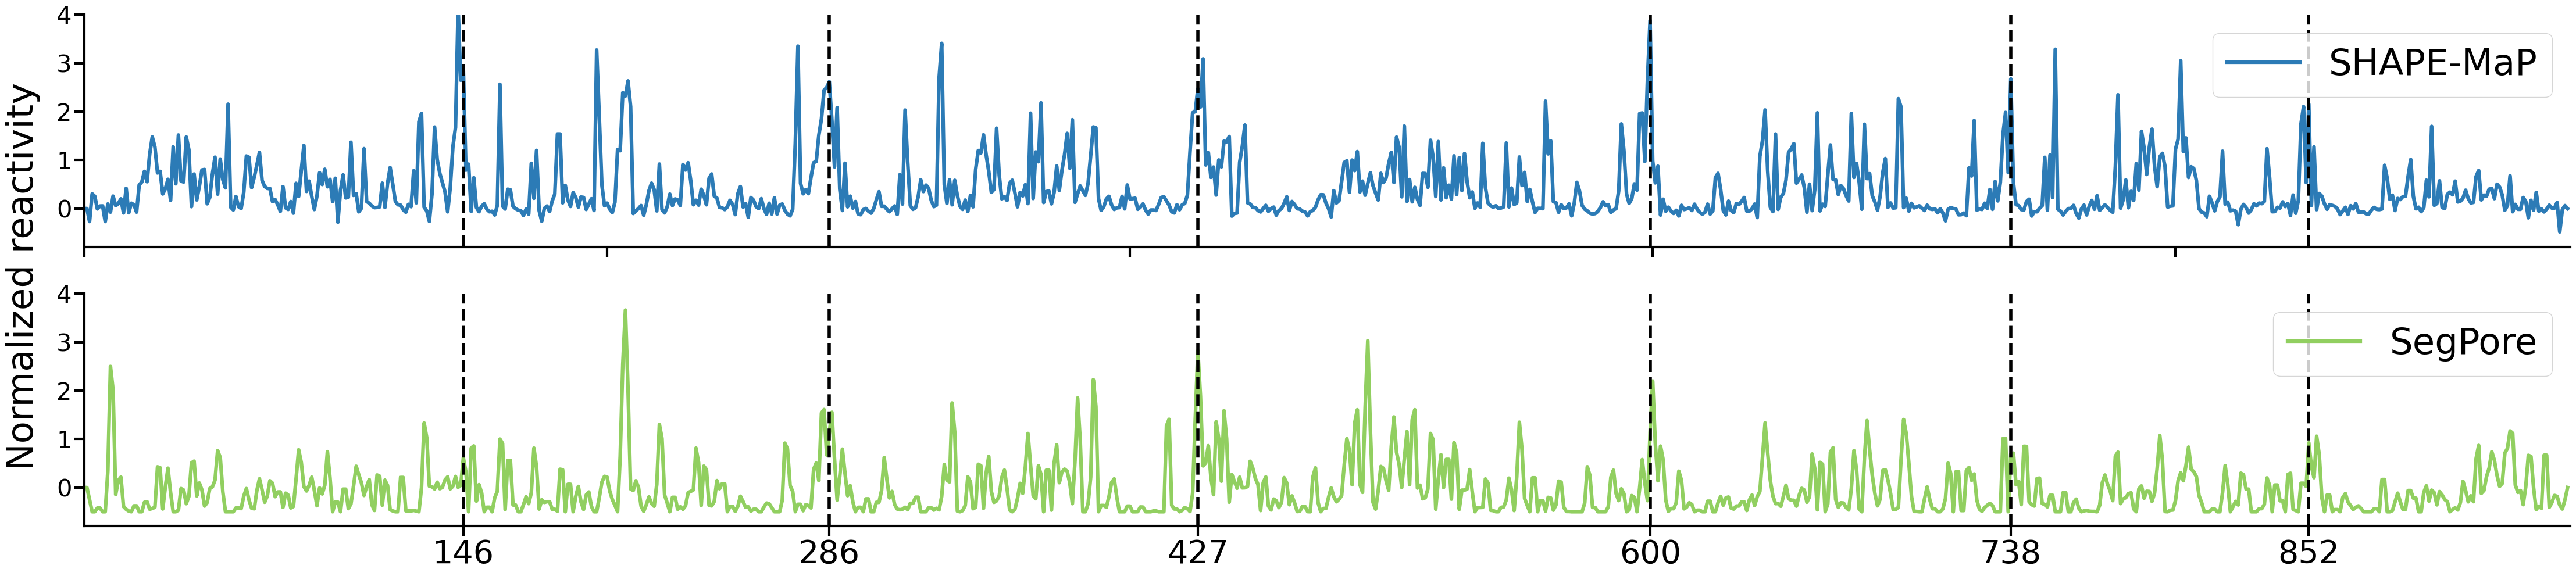

In [10]:
plot_reactivity(select_kmers_pos)